# Model Explainability, A/B testing and Shadow Testing 

Imagine you're a data scientist who has successfully developed a direct marketing AI model using Amazon SageMaker in the main section of this workshop. The model has shown promising results, and the value SageMakers ease of development and deployment has been proven to your manager. 

Based on that success, your manager has now tasked you with improving the model's accuracy and introducing A/B testing before putting it into production. Your call center agents have told you, that it is hard for them to know why the model has predicted the outcome and want to understand the 

As a data scientist, you recognize the importance of model explainability not only for improving model accuracy but also for providing insights that can help call center agents better tailor their message to customers. By providing explainable results, agents can better understand the factors driving a customer's likelihood to convert and adjust their messaging accordingly. 

In this notebook, we will explore how to incorporate explainability into the direct marketing AI model for the call center and provide a step-by-step guide for using A/B testing and shadow testing to evaluate the new model's performance. By doing so, we can ensure that the model is not only accurate but also transparent and understandable, empowering call center agents to effectively engage with customers and drive better outcomes.

## Prerequisites
To run this notebook you must have:
1. Complete the **Hyperparameter optimization** section from the [`02-sagemaker-containers`](../02-sagemaker-containers.ipynb) notebook

Alternatively you can create a new model that you would like to A/B test against the model trained by the [`step 3`](../03-sagemaker-pipeline.ipynb) pipeline.

In [65]:
# Run this cell if you are not using the latest SageMaker Python SDK

# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install --upgrade boto3 sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.8/685.8 kB 18.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 47.7 MB/s eta 0:00:0000:0100:01
  Created wheel for sagemaker: filename=sagemaker-2.142.0-py2.py3-none-any.whl size=927411 sha256=00d64b129efe143564673226d3ac8cac4c878d4469b316bd5e70d7e6a94281ef
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e4/d4/1e/42e1d45491d51e65e55a1e23336d621088e609d56497fe3b19
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.59
    Uninstalling botocore-1.27.59:
      Successfully uninstalled botocore-1.27.59
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.71
    Uninstalling boto3-1.26.71:
      Successfully uninstalled bot

In [1]:
import time
import os
import json
import boto3
import numpy as np  
import botocore
import pandas as pd 
import sagemaker
from time import gmtime, strftime, sleep
from sklearn.metrics import roc_auc_score
import sagemaker 
from time import gmtime, strftime, sleep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run
from sagemaker import get_execution_role
sagemaker.__version__

'2.142.0'

In [2]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")


Stored variables and their in-db values:
baseline_s3_url_catboost               -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
bucket_name                            -> 'sagemaker-us-east-1-510646607739'
bucket_prefix                          -> 'from-idea-to-prod/xgboost'
bucket_prefix_catboost                 -> 'from-idea-to-prod/catboost'
domain_id                              -> None
experiment_name                        -> 'Model-Improvement-Efforts-02-11-30-27'
initialized                            -> True
input_s3_url_catboost                  -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
output_s3_url                          -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
region                                 -> 'us-east-1'
sm_role                                -> 'arn:aws:iam::510646607739:role/service-role/Amazo
test_s3_url_catboost                   -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
train_s3_url_catboost                  -> 's3:

In [3]:
boto_session = boto3.Session()
region = boto_session.region_name
sm_session = sagemaker.Session()
sm = sm_session.sagemaker_client
bucket_name = sm_session.default_bucket()
bucket_prefix_xgboost = "from-idea-to-prod/xgboost"
bucket_prefix_catboost = "from-idea-to-prod/catboost"
# Define where the training job stores the model artifact
output_s3_url = f"s3://{bucket_name}/{bucket_prefix_catboost}/output"

%store output_s3_url
sm_session = sagemaker.Session()
sm_client = boto_session.client("sagemaker")
try:
    sm_role = sagemaker.get_execution_role()
except ValueError:
    print("No SageMaker execution role found. Using default role. Looking in a for a config file named 'config.json' in the current directory.")
    import json

    # Load the configuration file
    with open('../config.json', 'r') as f:
        config = json.load(f)

    # Access the execution_role field
    sm_role = config['sagemaker-execution-role']
    

initialized = True

print(sm_role)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Stored 'output_s3_url' (str)


No SageMaker execution role found. Using default role. Looking in a for a config file named 'config.json' in the current directory.
arn:aws:iam::510646607739:role/service-role/AmazonSageMaker-ExecutionRole-20220809T104176


In [4]:
# This cell is tagged with `parameters` tag and will be overwritten if the notebook executed headlessly
file_source = "EFS"
file_name = "bank-additional-full.csv"
input_path = "../data/bank-additional" 
output_path = "./data"

df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

pd.set_option("display.max_columns", 500)  # View all of the columns
df_data  # show first 5 and last 5 rows of the dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [5]:
experiment_name = f"Model-Improvement-Efforts-{strftime('%d-%H-%M-%S', gmtime())}"

In [6]:
%store experiment_name

Stored 'experiment_name' (str)


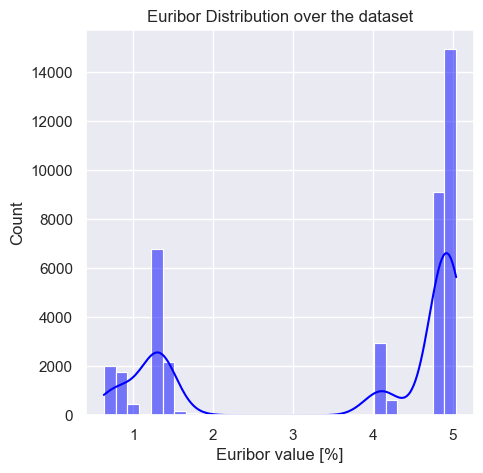

In [7]:
# plot the euribor data 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(df_data['euribor3m'], bins=30, kde=True, color='blue')
# set the title, x and y labels
plt.title('Euribor Distribution over the dataset')
plt.xlabel('Euribor value [%]')
plt.ylabel('Count')
plt.show()

As can be seen, the Euribor (the interest rate set by the European central bank for lending money to the banks) has strong fluctution in the recorded time. Therefore, we will leave it as a macro-economic feature. 

Furthermore, we will try to use a meaningful mapping wherever possible instead of just one-hot-encoding everything. As we already know how to use Processing Jobs, we will utilize it here directly.

In [8]:
train_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/train"
validation_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/validation"
test_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/test"
baseline_s3_url_catboost = f"s3://{bucket_name}/{bucket_prefix_catboost}/baseline"

In [9]:
%store train_s3_url_catboost
%store validation_s3_url_catboost
%store test_s3_url_catboost
%store baseline_s3_url_catboost

Stored 'train_s3_url_catboost' (str)
Stored 'validation_s3_url_catboost' (str)
Stored 'test_s3_url_catboost' (str)
Stored 'baseline_s3_url_catboost' (str)


In [10]:
# !pip install s3fs

In [11]:
df_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [16]:
%%writefile preprocessing_catboost.py

import pandas as pd
import numpy as np
import argparse
import os

def _parse_args():
    
    parser = argparse.ArgumentParser()
    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    
    return parser.parse_known_args()


if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    
    target_col = "y"
    
    # Load data
    df_data = pd.read_csv(os.path.join(args.filepath, args.filename), sep=";")

    # starting with the variables that have order and we want to map
    targetMapping = {'no':0, 'yes':1}
    educationMapping = {'illiterate':0, 'basic.4y':1, 'basic.6y':1, 'basic.9y':2,
                        'high.school':3,'professional.course':4, 'university.degree':5,
                        'unknown':-999}
    jobMapping = {'unemployed':0, 'student':1, 'housemaid':1, 'services':2,
                        'blue-collar':3,'technician':3, 'retired':3, 'self-employed':4,'management':5,  'entrepreneur':6,
                        'unknown':-999}
    maritalMapping = {'single':0, 'married':1, 'divorced':2,'unknown':-999}
    dayMapping = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
    monthMapping = {'jan': 1, 'feb': 2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    defaultMapping = {"no":0,"yes":1,"unknown":-999}
    housingMapping = {"no":0,"yes":1,"unknown":-999}
    loanMapping = {"no":0,"yes":1,"unknown":-999}
    poutcomeMapping = {"failure":0,"nonexistent":-999,"success":1}
    contactMapping = {'telephone':0, 'cellular':1}

    df = df_data.copy()
    df['y'] = df['y'].map(targetMapping)
    df['education'] = df['education'].map(educationMapping)
    df['day_of_week'] = df['day_of_week'].map(dayMapping)
    df['month'] = df['month'].map(monthMapping)
    df['default'] = df['default'].map(defaultMapping)
    df['housing'] = df['housing'].map(housingMapping)
    df['loan'] = df['loan'].map(loanMapping)
    df['poutcome'] = df['poutcome'].map(poutcomeMapping)
    df['contact'] = df['contact'].map(contactMapping)
    df['job'] = df['job'].map(jobMapping)
    df['marital'] = df['marital'].map(maritalMapping)
    df.drop('duration', axis = 1, inplace = True)
    df=df.fillna(-999)
    
    # reordering the columns 
    cols = df.columns.tolist()
    cols = [target_col] + [col for col in cols if col not in [target_col] ]
    df = df[cols] 
    # Shuffle and splitting dataset
    train_data, validation_data, test_data = np.split(
        df.sample(frac=1, random_state=1729),
        [int(0.7 * len(df)), int(0.9 * len(df))],
    )
    
    print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
    # Save datasets locally
    train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    
    # Save the baseline dataset for model monitoring
    df.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)
    
    print("## Processing complete. Exiting.")

Overwriting preprocessing_catboost.py


In [17]:
input_s3_url_catboost = sm_session.upload_data(
    path="../data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix_catboost}"
)
%store input_s3_url_catboost

Stored 'input_s3_url_catboost' (str)


In [20]:
framework_version = "0.23-1"
processing_instance_type = "ml.m5.large"
processing_instance_count = 1

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    role=sm_role,
    instance_type=processing_instance_type,
    # instance_type="local",
    instance_count=processing_instance_count, 
    base_job_name='from-idea-to-prod-processing',
    sagemaker_session=sm_session,
)

processing_inputs = [
        ProcessingInput(
            source=input_s3_url_catboost, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            # s3_data_distribution_type="ShardedByS3Key"
        )
    ]

processing_outputs = [
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_s3_url_catboost,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_s3_url_catboost
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_s3_url_catboost
        ),
        ProcessingOutput(
            output_name="baseline_data", 
            source="/opt/ml/processing/output/baseline", 
            destination=baseline_s3_url_catboost
        ),
    ]

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


## Testing if we improved the model with the new encoding


# Running a training job to get a baseline from catboost

Lets create a training job to get a baseline of catboost to see how we are doing against xgboost. 


In [22]:
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker import hyperparameters

train_model_id, train_model_version, train_scope = "catboost-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

training_job_name = name_from_base(f"built-in-algo-{train_model_id}-training")

# Retrieve the default hyperparameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)
# [Optional] Override default hyperparameters with custom values
hyperparameters[
    "iterations"
] = "500"
print(hyperparameters)

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=sm_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    # instance_type="local",
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=output_s3_url
)


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


{'iterations': '500', 'early_stopping_rounds': '5', 'eval_metric': 'Auto', 'learning_rate': '0.03', 'depth': '6', 'l2_leaf_reg': '3', 'random_strength': '1.0', 'max_leaves': '31', 'rsm': '1', 'sampling_frequency': 'PerTreeLevel', 'min_data_in_leaf': '1', 'bagging_temperature': '1', 'boosting_type': 'Auto', 'scale_pos_weight': '1.0', 'max_bin': 'Auto', 'grow_policy': 'SymmetricTree', 'random_seed': '0', 'thread_count': '-1', 'verbose': '1'}


In [23]:
# Launch a SageMaker Training job by passing the S3 path of the training data
tabular_estimator.fit(
    {
        "training": train_s3_url_catboost,
        "validation": validation_s3_url_catboost,
    }, logs=True, job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: built-in-algo-catboost-classification-m-2023-04-02-11-39-04-577


2023-04-02 11:39:07 Starting - Starting the training job...
2023-04-02 11:39:21 Starting - Preparing the instances for training...
2023-04-02 11:40:06 Downloading - Downloading input data...
2023-04-02 11:40:27 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-02 11:41:03,598 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-02 11:41:03,600 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-02 11:41:03,608 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-02 11:41:03,610 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-02 11:41:04,615 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/catboost/catbo

In [24]:
# create a confusion matrix for the model tested on the test dataset
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import os

# Download the test dataset
test_x_s3_url = os.path.join(test_s3_url_catboost, "test_x.csv")
test_y_s3_url = os.path.join(test_s3_url_catboost, "test_y.csv")

test_x_s3 = boto3.resource("s3").Object(bucket_name, test_x_s3_url.replace(f"s3://{bucket_name}/", ""))
test_x_s3.download_file("test_x.csv")



# Adding a HPO Job to find the best hyperparameters for the task at hand

In [25]:
# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

In [50]:
# set up hyperparameter ranges
hyperparameter_ranges_cat = {
    "learning_rate": ContinuousParameter(0.00001, 0.1, scaling_type="Logarithmic"),
    "iterations": IntegerParameter(50, 1000),
    "depth": IntegerParameter(1, 10),
    "l2_leaf_reg": IntegerParameter(1, 10),
    "random_strength": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}
# setting the name 
base_tuning_job_name = "Idea2ProdCatB-tuner"
print(base_tuning_job_name)

tuner = HyperparameterTuner(
    tabular_estimator,
    "AUC",
    hyperparameter_ranges_cat,
    [{"Name": "AUC", "Regex": "bestTest = ([0-9\\.]+)"}],
    max_jobs=20,
    max_parallel_jobs=5,
    objective_type="Maximize",
    base_tuning_job_name=base_tuning_job_name,
)

tuner.fit({"training": train_s3_url_catboost}, logs=True)

tuner.wait()

Idea2ProdCatB-tuner


INFO:sagemaker:Creating hyperparameter tuning job with name: Idea2ProdCatB-tuner-230402-2019


..............................................................................!
!


In [51]:
# return the name of the hyperparameter tuning job name from the last run 
tuner.latest_tuning_job.name

'Idea2ProdCatB-tuner-230402-2019'

In [57]:
tuning_job_name=tuner.latest_tuning_job.name
print(tuning_job_name)
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

Idea2ProdCatB-tuner-230402-2019
20 training jobs have completed


In [58]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 4, 2, 20, 24, 44, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'AUC',
                                                 'Value': 0.8009076714515686},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 4, 2, 20, 25, 33, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:555555555555:training-job/Idea2ProdCatB-tuner-230402-2019-019-d3c1589b',
 'TrainingJobName': 'Idea2ProdCatB-tuner-230402-2019-019-d3c1589b',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 4, 2, 20, 24, 51, tzinfo=tzlocal()),
 'TunedHyperParameters': {'depth': '9',
                          'iterations': '486',
                          'l2_leaf_reg': '4',
                          'learning_rate': '0.00024377077948554255',
                          'random_strength': '0.05420707610695903'}}


In [60]:
full_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
print(f"Shape of the dataframe for all tuning jobs: {full_df.shape}")

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")
df.head()

Shape of the dataframe for all tuning jobs: (20, 11)
Number of training jobs with valid objective: 20
{'lowest': 0.7716031670570374, 'highest': 0.8009076714515686}


,depth,iterations,l2_leaf_reg,learning_rate,random_strength,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,9.0,486.0,4.0,0.000244,0.054207,Idea2ProdCatB-tuner-230402-2019-019-d3c1589b,Completed,0.800908,2023-04-02 20:24:51+02:00,2023-04-02 20:25:33+02:00,42.0
13,9.0,451.0,6.0,0.000489,0.044629,Idea2ProdCatB-tuner-230402-2019-007-2fab68a5,Completed,0.799091,2023-04-02 20:22:18+02:00,2023-04-02 20:23:05+02:00,47.0
2,8.0,539.0,3.0,0.000263,0.050836,Idea2ProdCatB-tuner-230402-2019-018-c1c4f014,Completed,0.799062,2023-04-02 20:25:12+02:00,2023-04-02 20:25:48+02:00,36.0
4,9.0,580.0,8.0,0.000485,0.063765,Idea2ProdCatB-tuner-230402-2019-016-c5546782,Completed,0.797897,2023-04-02 20:24:27+02:00,2023-04-02 20:25:14+02:00,47.0
15,9.0,695.0,2.0,0.000811,0.136229,Idea2ProdCatB-tuner-230402-2019-005-91a6d3de,Completed,0.797727,2023-04-02 20:20:21+02:00,2023-04-02 20:21:52+02:00,91.0


In [61]:
# get the best performing model
best_training_job = tuning_job_result["BestTrainingJob"]
best_training_job_name = best_training_job["TrainingJobName"]
print("Best model: " + best_training_job_name)

# deploy the best performing model
best_model = sagemaker.model.Model(
    image_uri=best_training_job["TrainingJobDefinition"]["AlgorithmSpecification"]["TrainingImage"],
    model_data=best_training_job["TunedModelArtifacts"]["S3ModelArtifacts"],
    role=sm_role,
    sagemaker_session=sagemaker_session,
)

Best model: Idea2ProdCatB-tuner-230402-2019-019-d3c1589b


KeyError: 'TrainingJobDefinition'

In [ ]:

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type=endpoint_instance_type,
    endpoint_name=best_training_job_name,
)

# get the test dataset
test_x_s3_url = os.path.join(test_s3_url_catboost, "test_x.csv")
test_y_s3_url = os.path.join(test_s3_url_catboost, "test_y.csv")

test_x_s3 = boto3.resource("s3").Object(bucket_name, test_x_s3_url.replace(f"s3://{bucket_name}/", ""))
test_x_s3.download_file("test_x.csv")

test_y_s3 = boto3.resource("s3").Object(bucket_name, test_y_s3_url.replace(f"s3://{bucket_name}/", ""))
test_y_s3.download_file("test_y.csv")

# load the test dataset
test_x = pd.read_csv("test_x.csv", index_col=0)
test_y = pd.read_csv("test_y.csv", index_col=0)

# get predictions from the model
predictions = predictor.predict(test_x)

# convert predictions to a dataframe
predictions = pd.DataFrame(predictions, columns=["prediction"])

# convert the predictions to a binary classification
predictions["prediction"] = predictions["prediction"].apply(lambda x: 1 if x > 0.5 else 0)

# get the confusion matrix
confusion_matrix = confusion_matrix(test_y, predictions)

# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()


### Setting up some visualisation functions

In [36]:
def force_plot(expected_value, shap_values, feature_data, feature_headers):
    """
    Visualize the given SHAP values with an additive force layout.

    For more information: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html
    """
    force_plot_display = shap.plots.force(
        base_value=expected_value,
        shap_values=shap_values,
        features=feature_data,
        feature_names=feature_headers,
        matplotlib=True,
    )


def display_plots(explanations, expected_value, request_records, predictions):
    """
    Display the Model Explainability plots
    """
    per_request_shap_values = OrderedDict()
    feature_headers = []
    for i, record_output in enumerate(explanations):
        per_record_shap_values = []
        if record_output is not None:
            feature_headers = []
            for feature_attribution in record_output:
                per_record_shap_values.append(
                    feature_attribution["attributions"][0]["attribution"][0]
                )
                feature_headers.append(feature_attribution["feature_header"])
            per_request_shap_values[i] = per_record_shap_values

    for record_index, shap_values in per_request_shap_values.items():
        print(
            f"Visualize the SHAP values for Record number {record_index + 1} with Model Prediction: {predictions[record_index][0]}"
        )
        force_plot(
            expected_value,
            np.array(shap_values),
            request_records.iloc[record_index],
            feature_headers,
        )


def visualize_result(result, request_records, expected_value):
    """
    Visualize the output from the endpoint.
    """
    predictions = pd.read_csv(io.StringIO(result["predictions"]["data"]), header=None)
    predictions = predictions.values.tolist()
    print(f"Model Inference output: ")
    for i, model_output in enumerate(predictions):
        print(f"Record: {i + 1}\tModel Prediction: {model_output[0]}")

    if "kernel_shap" in result["explanations"]:
        explanations = result["explanations"]["kernel_shap"]
        display_plots(explanations, expected_value, request_records, predictions)
    else:
        print(f"No Clarify explanations for the record(s)")


In [34]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool


class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type="datetime")
p.circle(source=df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

Loading BokehJS ...

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [35]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get("Values"):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0

        vals = hp_range["Values"]
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args["x_range"] = vals

    # Now plot it
    p = figure(
        plot_width=500,
        plot_height=500,
        title="Objective vs %s" % hp_name,
        tools=hover.tools(),
        x_axis_label=hp_name,
        y_axis_label=objective_name,
        **categorical_args,
    )
    p.circle(source=df, x=hp_name, y="FinalObjectiveValue")
    figures.append(p)
show(bokeh.layouts.Column(*figures))

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [ ]:
print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")
    
# Save datasets locally
train_data.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
validation_data.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
test_data[target_col].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
test_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)

# Save the baseline dataset for model monitoring
df_model_data.drop([target_col], axis=1).to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)

print("## Processing complete. Exiting.")

<AxesSubplot: title={'center': 'Duration of calls histogram [sec]'}, ylabel='Frequency'>

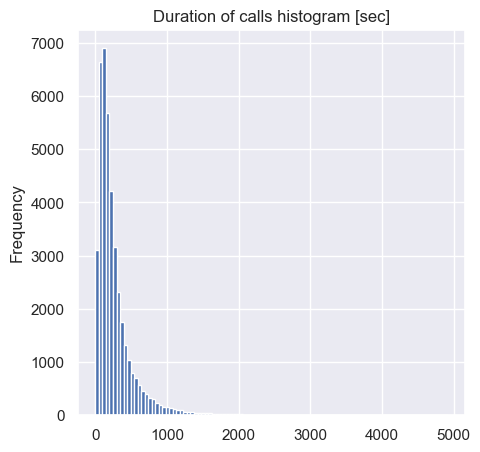

In [41]:
# plot the duration data and color it by the target variable
df.duration.plot(kind='hist', bins=100, title='Duration of calls histogram [sec]')

In [54]:
# how long does a call usually take if the call was not successful? 
(df.loc[(df["duration"]>0) & (df["y"]==1)].duration/60).describe()

count    4640.000000
mean        9.219853
std         6.686198
min         0.616667
25%         4.216667
50%         7.483333
75%        12.354167
max        69.983333
Name: duration, dtype: float64

In [55]:
# how long does a call usually take if the call was not successful? 
(df.loc[(df["duration"]>0) & (df["y"]==0)].duration/60).describe()

count    36544.000000
mean         3.681150
std          3.451579
min          0.016667
25%          1.583333
50%          2.733333
75%          4.650000
max         81.966667
Name: duration, dtype: float64

## Further development ideas for your real-world projects

## Additional resources
- [Safely validate models in production](https://docs.aws.amazon.com/sagemaker/latest/dg/model-validation.html)
- [A/B Testing with Amazon SageMaker](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_endpoints/a_b_testing/a_b_testing.html)
- [A/B Testing ML models in production using Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/a-b-testing-ml-models-in-production-using-amazon-sagemaker/)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>